In [148]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [149]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# End-to-End Multi-class Dog Breed Classification

Using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem

Identifying Breed of a dog given the image of a dog.

## 2 .Data

The Data we're using is from kaggle's dog breed identification completition.
You can find it in datasets from Input Tab in Kaggle Notebooks

## Evaluation

The evaluation is a file with prediction probabilities for each dog breed for each dog image.
**MultiClassLogLoss**

## Features

Some information about the data.
* We're dealing with images (unstructured data) so it's best we use deep learning/ transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10000+  images in training set (with labels), and same in test set (with no labels)


### Getting our workspace ready:
* Import TensorFlow version 2.x
* Import Tenflow Hub
* Make Sure we are using a GPU

In [150]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
print("TF Version:", tf.__version__)
print("TF Hub Version", hub.__version__)

# Check availablity of GPU
print("GPU", "available (YESS!!!)" if tf.config.list_physical_devices("GPU") else 'Not available :(')

TF Version: 2.16.1
TF Hub Version 0.16.1
GPU available (YESS!!!)


## Getting our Data Ready (Turning into Tensors)

With all machine Models , our data has to be numerical formal.
Turning Images into Tensors(numerical representation)

Let's start by accessing our data and checking out labels.

In [151]:
labels_csv = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126

In [152]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

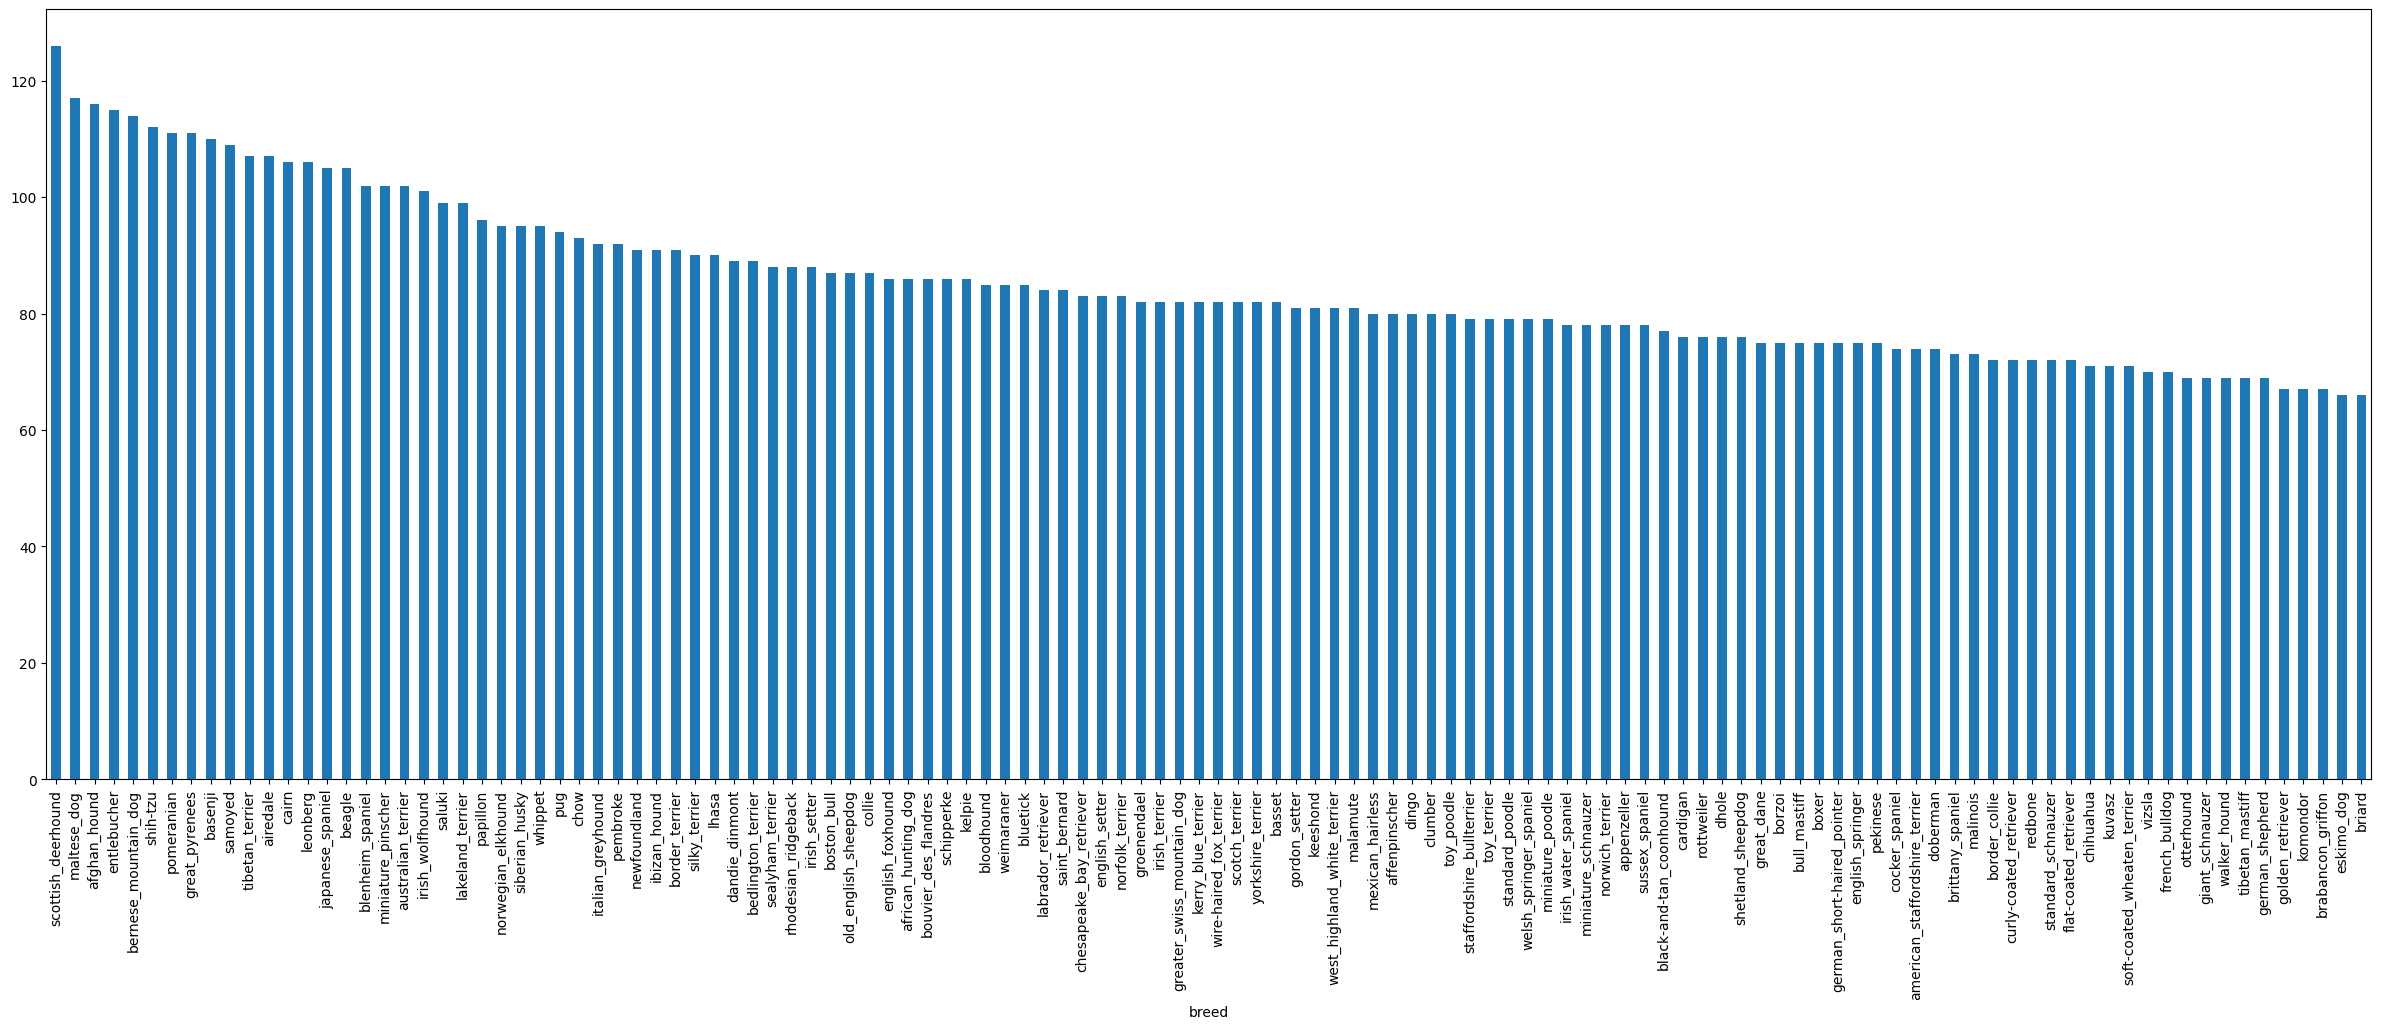

In [153]:
# How many images are there per each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(30, 10))

Google Suggests that we should have minimum of 10 images per class for a model training to be useful.

In [154]:
labels_csv["breed"].value_counts().median()

82.0

### Lets check our images

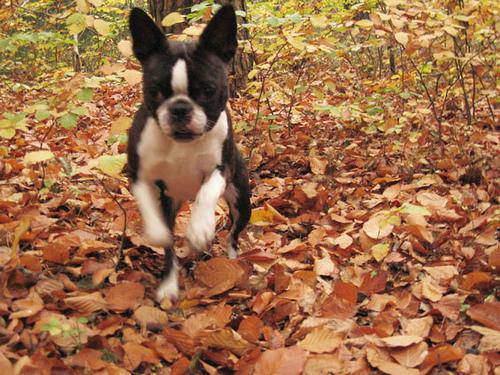

In [155]:
from IPython.display import Image
Image("/kaggle/input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

###  Getting Images and their labels

Let's get a list of all our image file pathnames

In [156]:
filenames = [f"/kaggle/input/dog-breed-identification/train/{fname}.jpg" for fname in labels_csv['id']]

In [157]:
filenames[:10]

['/kaggle/input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/kaggle/input/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/kaggle/input/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/kaggle/input/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/kaggle/input/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/kaggle/input/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/kaggle/input/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/kaggle/input/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/kaggle/input/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/kaggle/input/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [158]:
# check whether number of filenames matches number of actual image files
import os 
if len(os.listdir("/kaggle/input/dog-breed-identification/train/")) == len(filenames):
    print("Filenames match actual amount of files! Proceed.")
else:
    print("Filenames do not match actual number of files! Check the target directory")

Filenames match actual amount of files! Proceed.


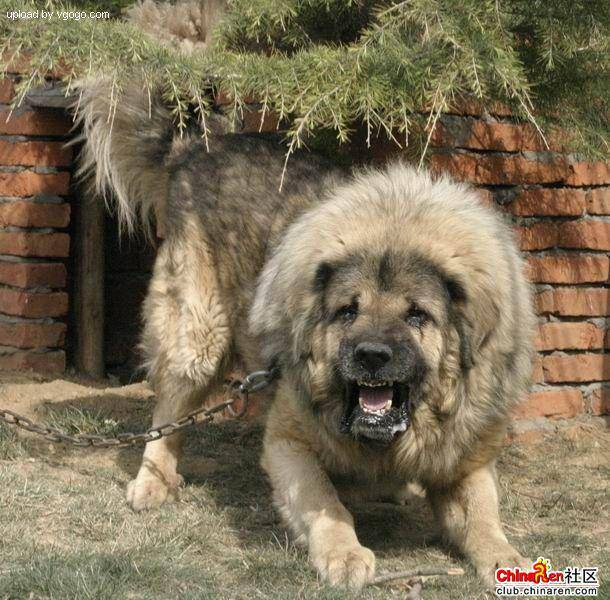

In [159]:
# One More check
Image(filenames[9000])

In [160]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in alist, **let's prepare our labels**

In [161]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels) # does the same thing
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [162]:
# Check if number of labels matches the number of filenames
len(labels) == len(filenames)

True

In [163]:
# find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [164]:
# Turn a Single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds # return bool array , which has true for the index where value == label[0]

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [165]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[: 2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [166]:
len(boolean_labels)

10222

In [167]:
# Example Turning Boolean arrays into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean Array
print(boolean_labels[0].astype(int)) # there will be 1 in the label where actual label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# Creating Our Own validation set
Since the dataset from Kaggle doesn't come with a Validation set, We will create our own.

In [168]:
# Setup X and y Variables
X = filenames
y = boolean_labels

## Minimize the time between experimentation.
Lets start with 1000 images and increase as needed

In [169]:
from kaggle_secrets import UserSecretsClient

# Create a slider for NUM_IMAGES
NUM_IMAGES = 1000  # Default value

In [170]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES],
                                                 test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)


(800, 800, 200, 200)

## Turning Images into Tensors (Preprocessing Images)

- Take Image_Path as input
- Use TensorFlow to read the file and save it to a varaible `image`
- Turn our `image`(.jpg) into Tensors
- Resize the `image` to be a shape of (224, 224)
- Return Modified Image

In [171]:
# Covert an Image to a NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

**There are 3 color channels for R G B, each has value in range (0, 255)**

In [172]:
image.max(), image.min()

(255, 0)

In [173]:
# Image to Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Make a function to
- Take Image_Path as input
- Use TensorFlow to read the file and save it to a varaible `image`
- Turn our `image`(.jpg) into Tensors
- Normalize our Tensors 
- Resize the `image` to be a shape of (224, 224)
- Return Modified Image

In [174]:
# Define image size
IMG_SIZE = 224

# create a function to preprocess the image
def preprocess_image(image_path, img_size=IMG_SIZE):
    """Takes an Image_Path and converts to a image tensor"""
    image = tf.io.read_file(image_path)
    # Turn jpeg image into numerical Tensor with 3 colour channels
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert colour channel values from 0 to 255 --> 0 to 1 (Normalization)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize our image
    image = tf.image.resize(image, size=[img_size, img_size])

    return image

## Turning our Data into Batches
 Why make batches?  (less than 32)

Let's say you're trying to process 10,000+ images in one go... they might nor fit into memory.

So that's why we do about 32 (our batch size) images at a time ( you can manually adjust the batch size if need be).

I  order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:

`(image, label)` [Supervised Learning]

In [175]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """Processes an image file path and the associated label, returns a tuple (image, label)"""
    image = preprocess_image(image_path)
    return image, label

In [176]:
# Demo of the above
(preprocess_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`

Let's make a function to turn all of our data (X & y) into batches!

In [177]:
# Define the batch size , 32 is a good start
BATCH_SIZE = 32

# Create a function to turn our data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffles if it's validation data.
    Also accepts test_data as input (no labels)
    """
    # Test Data - no labels
    if test_data:
        print("Creating test data batches....")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # Only filepaths (no labels)
        data = data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        data = data.batch(batch_size)
        return data.prefetch(tf.data.AUTOTUNE)

    # Both training and validation need labels
    print("Creating {} data batches...".format("validation" if valid_data else "training"))
    
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    if not valid_data:
        data = data.shuffle(buffer_size=len(X))

    data = data.map(get_image_label, num_parallel_calls=tf.data.AUTOTUNE)

    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    

In [178]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [179]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize this

In [180]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a batch
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 23 ( for dirsplaying 25 images)
    for i in range(25):
        # Create Subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid line off
        plt.axis("off")
        

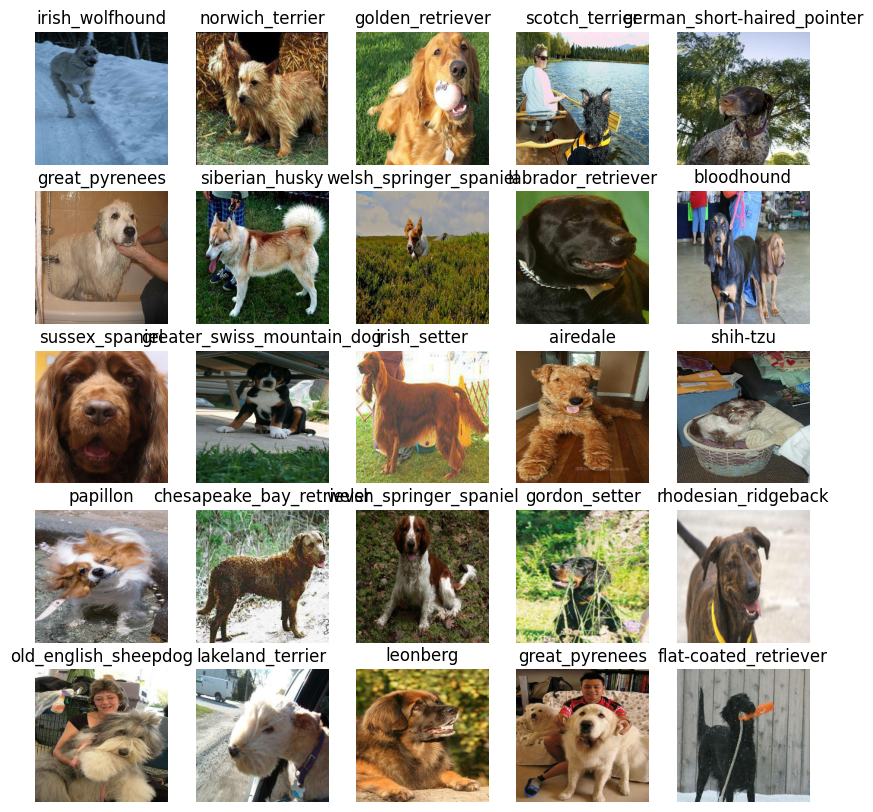

In [181]:
# Now visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

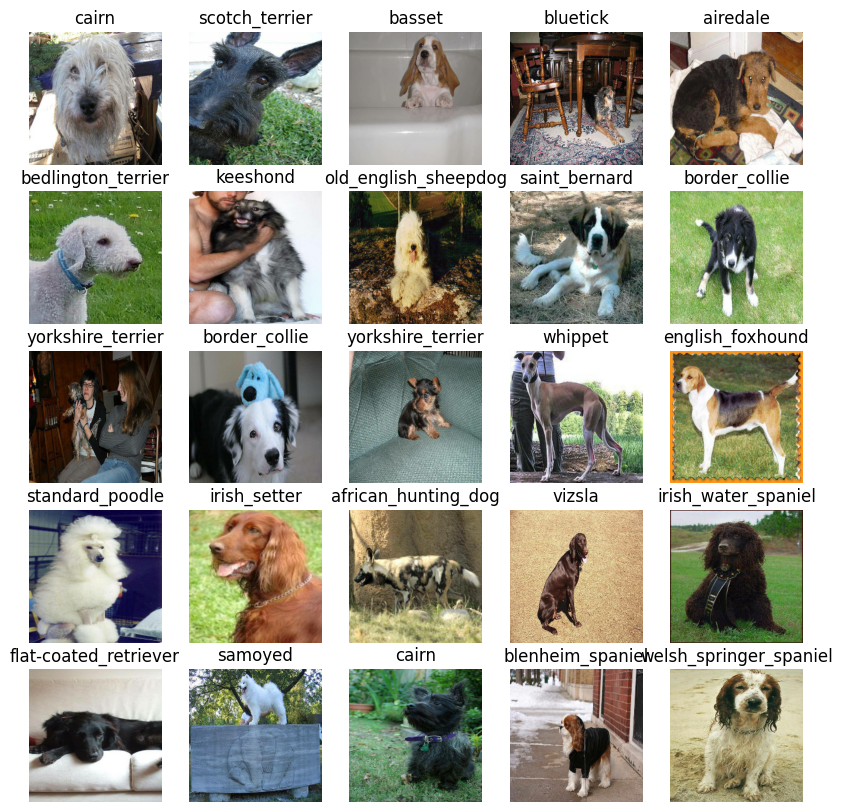

In [182]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a Model

Now that the input images are turned into numerical format (tensors), Let's go on and build a model. Before that, there are a few things we need to define:

- input shape (our image shape) in our models.
- output shape (image labels, in the form of Tensors (One hot encoded)
- The URL of model we want to use (fine-tuning a pre-trained model)

In [183]:
IMG_SIZE

224

In [184]:
# !pip install --upgrade tensorflow

In [185]:
# !pip install --upgrade tensorflow-decision-forests tensorflow-text 

In [186]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

def create_model(input_shape, output_shape, model_url):
    """
    Creates and compiles a TensorFlow model with a pre-trained base and custom output layer.
    
    Parameters:
    - input_shape: list or tuple, shape of the input (e.g., [None, IMG_SIZE, IMG_SIZE, 3])
    - output_shape: int, number of output classes
    - model_url: str, URL of the pre-trained model from TensorFlow Hub
    
    Returns:
    - model: Compiled TensorFlow Keras model
    """
    features_extraction_layer = hub.KerasLayer(model_url,
                                               name="features_extraction_layer",
                                               trainable=False,)
    # Initialize the model
    model = tf_keras.Sequential([
        tf_keras.layers.InputLayer(input_shape=input_shape),
        features_extraction_layer,
        tf_keras.layers.Dense(units=output_shape, activation="softmax")  # Output layer
    ])
    
    # Compile the model
    model.compile(
        loss=tf_keras.losses.CategoricalCrossentropy(),
        optimizer=tf_keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    
    # Build the model with the provided input shape
    model.build(input_shape)
    
    return model


For Pretrained Models Search in `Model Zoo`, `Tensorflow Hub` (Kaggle Api), `Pytorch Hub`, `Papers with Code` 

In [187]:
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"
model = create_model(INPUT_SHAPE, OUTPUT_SHAPE, MODEL_URL)

## Creating Callbacks

Callbacks are helper functions that a model can use during training to do such things as save its progress, check its progress or stop training early if model stops improving.


We'll create 2 callbacks, one for TensorBoard which helps track our model's progress and another for early stopping which prevents our model from training for too long.

## TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension ✔
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function
3. Visualize our model's training logs with TensorBoard magic function(we'll do this after model training)

In [188]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [189]:
from datetime import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("/kaggle/working/logs/", datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf_keras.callbacks.TensorBoard(logdir)



### Early Stopping Callback

Early stopping helps our model from overfitting by stopping training if a certain evaluation stops improving.

In [190]:
early_stopping = tf_keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=3, restore_best_weights=True)

In [192]:
## Training a model (on a subset of the data) - to make sure everything is working well

NUM_EPOCHS = 100

Let's create a function that trains a model

* Create a model using create_model()
* Setup a TensorBoard callback using 'create_tensorboard_callback()'
* call the fit() function on our model passing it the training data, validation data, numbers of epochs to traing for (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model

In [193]:
# Build a model and return the trained model
def train_model(train_data, val_data, input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    """
    Trains a model and return the trained model
    """
    # Create a Model
    model = create_model(input_shape=input_shape, output_shape=output_shape, model_url=model_url)

    # Create a TensorBoard session everttime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data
    history = model.fit(x=train_data, epochs=NUM_EPOCHS, validation_data=val_data, validation_freq=1, callbacks=[tensorboard, early_stopping])

    # returns the fitted model
    return model, history

In [194]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)
model, history = train_model(train_data, val_data)

Creating training data batches...
Creating validation data batches...
Epoch 1/100
25/25 [==============================] - 6s 96ms/step - loss: 4.6634 - accuracy: 0.0825 - val_loss: 3.3389 - val_accuracy: 0.2750
Epoch 2/100
25/25 [==============================] - 2s 65ms/step - loss: 1.6838 - accuracy: 0.6675 - val_loss: 2.1440 - val_accuracy: 0.5400
Epoch 3/100
25/25 [==============================] - 2s 65ms/step - loss: 0.5934 - accuracy: 0.9162 - val_loss: 1.6665 - val_accuracy: 0.6250
Epoch 4/100
25/25 [==============================] - 2s 65ms/step - loss: 0.2628 - accuracy: 0.9862 - val_loss: 1.4814 - val_accuracy: 0.6550
Epoch 5/100
25/25 [==============================] - 2s 68ms/step - loss: 0.1496 - accuracy: 0.9975 - val_loss: 1.3985 - val_accuracy: 0.6900
Epoch 6/100
25/25 [==============================] - 2s 63ms/step - loss: 0.1027 - accuracy: 0.9987 - val_loss: 1.3540 - val_accuracy: 0.6900
Epoch 7/100
25/25 [==============================] - 2s 62ms/step - loss: 0.07

### The Model is overfitting

It's performing far better on training dataset than on validation dataset. What are some ways to prevent overfitting in deeplearning?

**Note**: Overfitting is good thing as a start, it means our model is learning

### Checking TensorBoard logs

the TensorBoard magic function (%tensorboard) will access the logs directory we have created earlier and visualize its contents.

In [195]:
%tensorboard --logdir /kaggle/working/logs/

Reusing TensorBoard on port 6006 (pid 511), started 2:23:54 ago. (Use '!kill 511' to kill it.)

In [196]:
## Making and evaluating predictions using a trained model
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 55ms/step


array([[5.24605741e-04, 1.03623541e-04, 1.51330675e-03, ...,
        5.10096783e-04, 1.89032944e-05, 1.00988429e-03],
       [1.43759958e-02, 3.60845996e-04, 1.93373561e-02, ...,
        2.61676323e-04, 7.06716487e-03, 2.93301098e-04],
       [4.68381149e-05, 8.33764148e-04, 4.09471249e-04, ...,
        4.37982730e-04, 3.07749506e-05, 1.91650572e-04],
       ...,
       [4.05593819e-05, 8.78975770e-05, 1.90843930e-04, ...,
        3.27433409e-05, 5.24835850e-05, 1.15810995e-04],
       [1.54932681e-02, 3.05857509e-04, 1.50316147e-04, ...,
        8.45595321e-04, 1.07592510e-04, 1.15352497e-02],
       [3.21018946e-04, 1.52444438e-04, 1.79967168e-03, ...,
        1.17207458e-02, 6.86565880e-04, 2.61447189e-04]], dtype=float32)

In [197]:
np.sum(predictions[0])

1.0000001

In [198]:
predictions.shape

(200, 120)

In [199]:
len(y_val)

200

In [200]:
index = 42
print("Max value (probability of prediction):", np.max(predictions[index]))
print("Sum:", (np.sum(predictions[index])))
print("Max Index:", np.argmax(predictions[index]) )
print("Predicted Label", unique_breeds[np.argmax(predictions[index])])

Max value (probability of prediction): 0.6256939
Sum: 1.0
Max Index: 113
Predicted Label walker_hound


Having the above functionality is great but we want to be able to do it at scale.

And it would be better if we could see the image the prediction is being made on.

In [201]:
# Turn prediction Probablities into their repsective labels (easier to understand)

def get_pred_labels(prediction_probabilities):
    """
    Turns an array of predictio probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]
    

In [202]:
pred_label = get_pred_labels(predictions[42])
pred_label

'walker_hound'

In [203]:
val_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Now Since our validation data is still in a batch dataset, 
we'll have to unbatch it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [204]:
## create a function to unbatch a batched data
def unbatchify(batched_data):
    images = []
    labels = []

    for image, label in batched_data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

In [205]:
val_images, val_labels = unbatchify(val_data)

In [206]:
get_pred_labels(val_labels[0])

'affenpinscher'

Now we've got ways to get :
* Prediction labels
* Validation labels (truth labels)
* validation Images

Let's make some function to make these all a bit more visual.

We'll create a function which:
* Takes an array of predictions probabilities, an array of truth labels and an array of images and integers
* Convert the prediction probabilities to a predicted label
* plot the predicted label, its predicted probabilities, truth label, the target image on a single plot

In [207]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # get the pred label
    pred_label = get_pred_labels(pred_prob)

    # plot Image & Remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    if pred_label == true_label:
        color = "green"
    else:
        color = "red"
        

    # Change plot title to be predicted, probability of prediction and the truth label
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label), color=color)
              
    

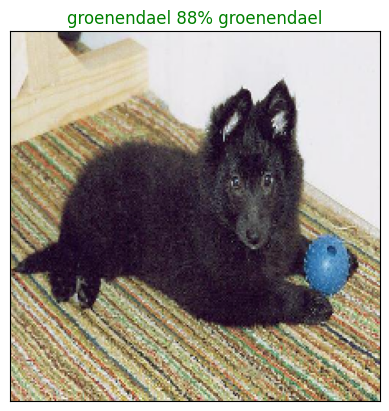

In [208]:
plot_pred(prediction_probabilities=predictions,
         labels=val_labels,images=val_images, n=77)

Now we've got one function to visualize our model's top prediction, let's make another function to view our model's top 10 predictions.

This function will:
* Take an input of prediction_probabilities, a ground truth and an integer
* Find the prediction using get_pred_labels()
* Find the top 10:
   - Prediction probabilities indexes.
   - prediction probabilities values.
   - Prediction labels
* plot the top 10 prediction probability values and labels, coloring the true label green

In [209]:
def plot_pred_conf(prediction_probabilites, labels, images, n=1):
    """
    Plus the To 10 highest prediction confidences along with the truth label for sample n
    """
    pred_prob, true_label = prediction_probabilites[n], labels[n]

    pred_label = get_pred_labels(pred_prob)

    # Find the to 10 predictio confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

    # FInd the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]

    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), top_10_pred_values, color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)), labels=top_10_pred_labels, rotation="vertical")

    if pred_label == true_label:
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    elif np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == pred_label)].set_color("red")
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
        
    
    

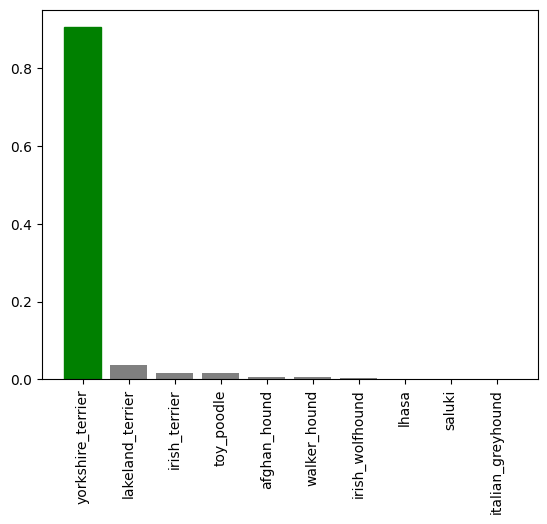

In [210]:
plot_pred_conf(predictions, val_labels, val_images, n=10)

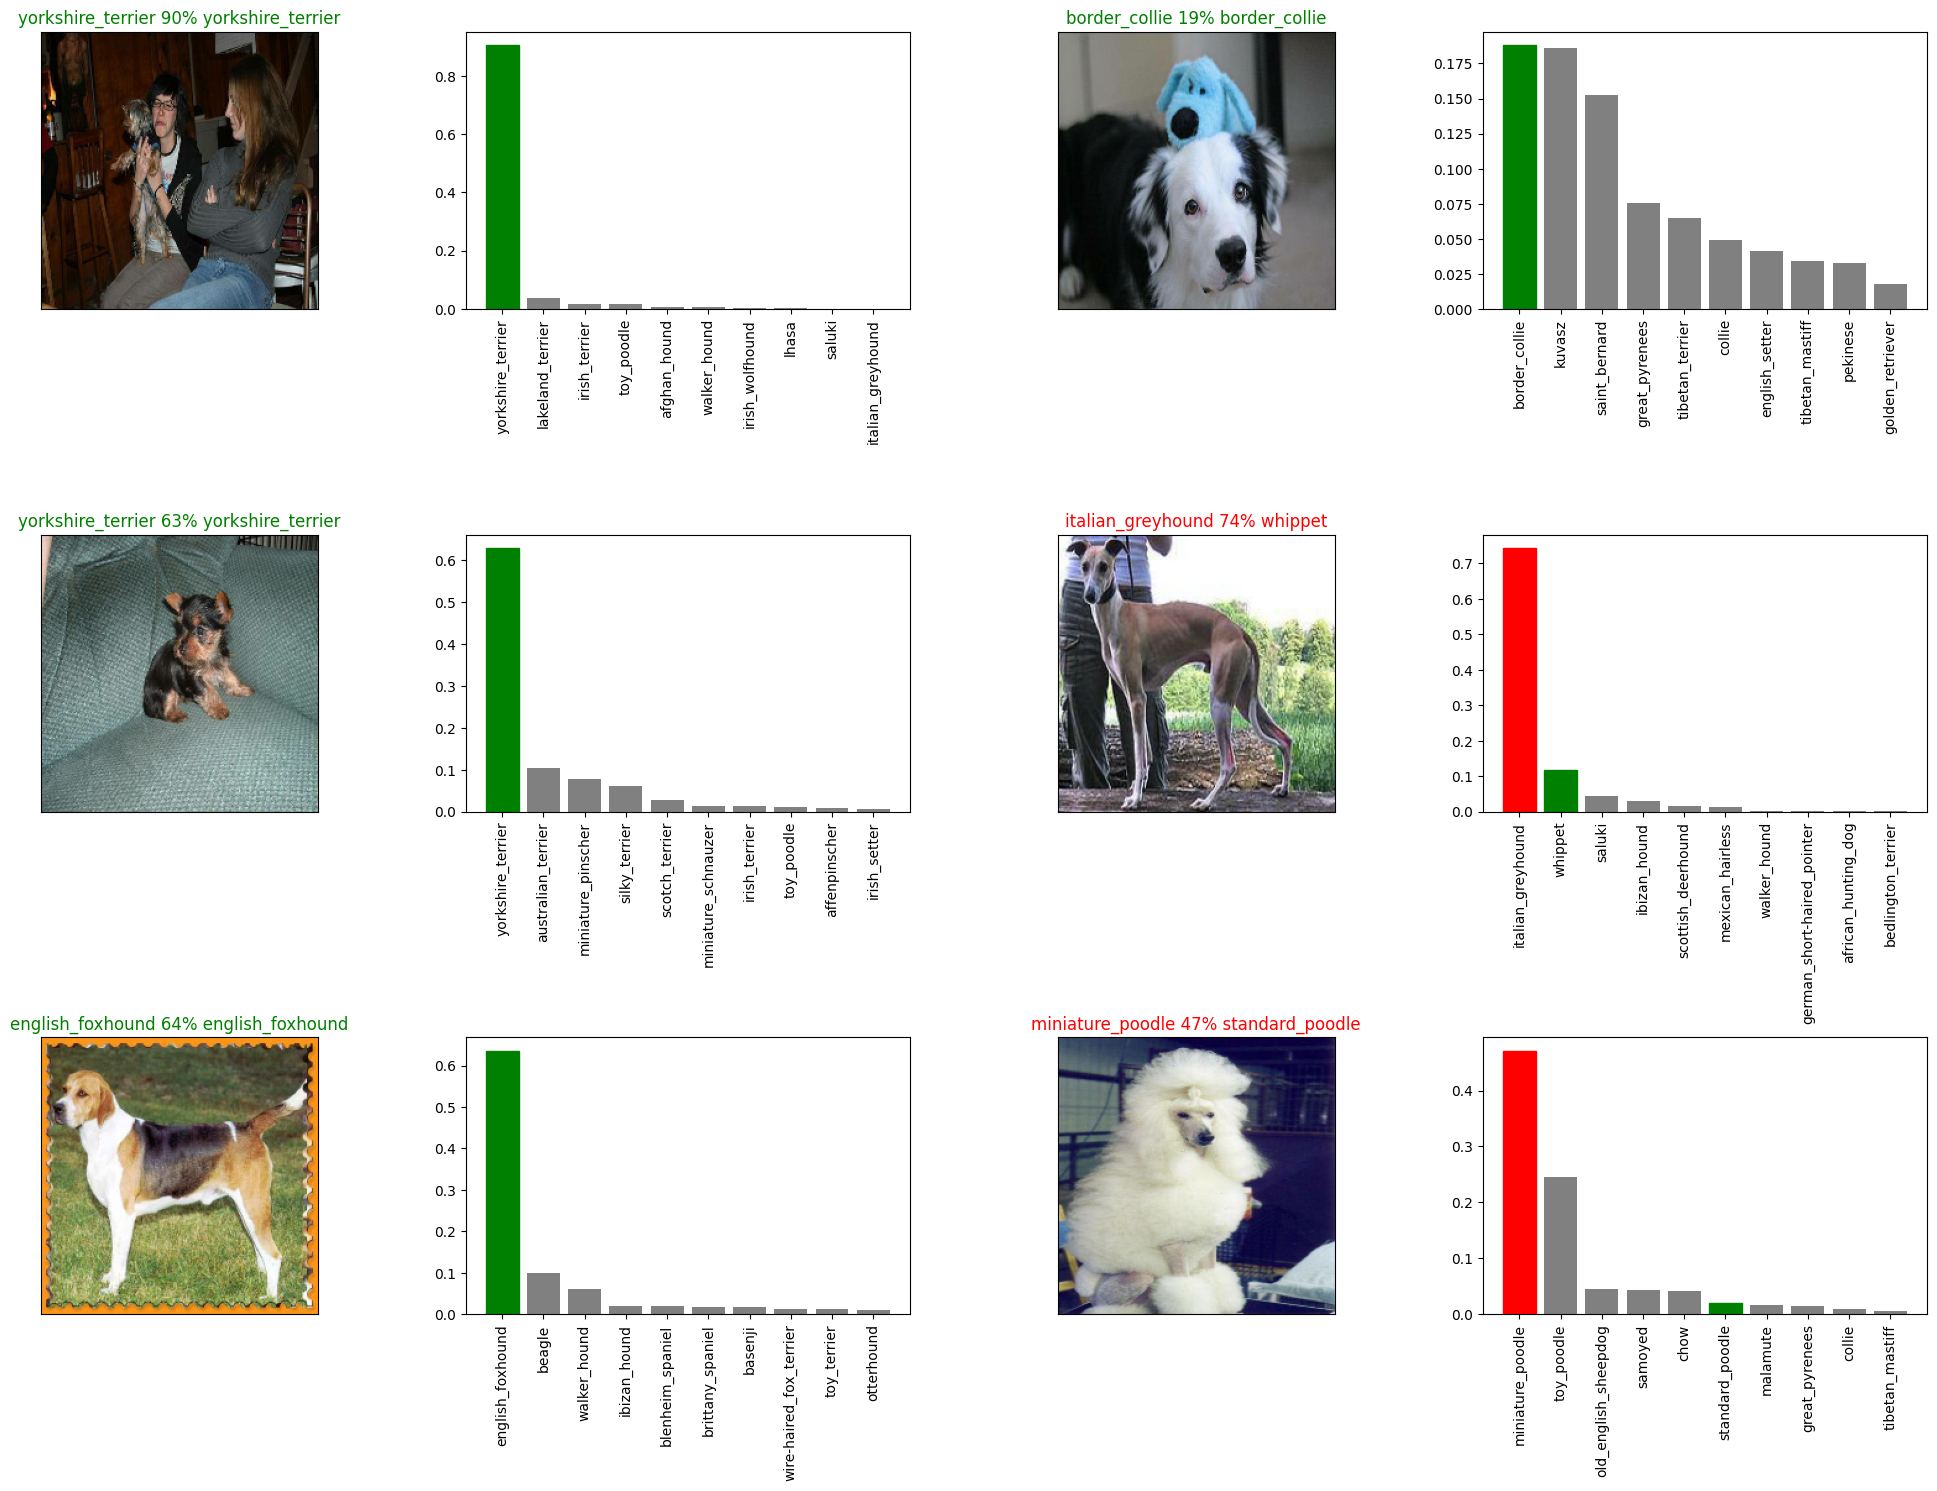

In [211]:
# Let's check out a few predictions and their different values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(predictions, val_labels, val_images, i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(predictions, val_labels, val_images, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge**: How would you create a confusion matrix with our models predictions and true labels

# Saving and reloading our model

In [212]:
# Create a function to save our model
def save_model(model, suffix=None, dir=None):
    """
    Saves a given model in a models directory and appends a suffix string (string).
    """
    # Create a model directory pathname with current time
    model_dir = os.path.join(dir or "/kaggle/working/saved_models/")
    model_path = model_dir + "-" + suffix + ".h5" # Save format
    print(f"Saving Model to :{model_path}....")
    model.save(model_path)
    return model_path
    

In [213]:
def load_model(model_path):
    """
    Loads a Saved Model from a model_path
    """
    print(f"Loading Saved Model from: {model_path}")
    model = tf_keras.models.load_model(model_path,
                                      custom_objects={"KerasLayer":hub.KerasLayer})
    return model

In [214]:
# Now we've got functions to load and train our model
# Lets try them

save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving Model to :/kaggle/working/saved_models/-1000-images-mobilenetv2-Adam.h5....


/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/kaggle/working/saved_models/-1000-images-mobilenetv2-Adam.h5'

In [215]:
loaded_1000_image_model = load_model("/kaggle/working/saved_models/-1000-images-mobilenetv2-Adam.h5")

Loading Saved Model from: /kaggle/working/saved_models/-1000-images-mobilenetv2-Adam.h5


In [216]:
# Evaluate the loaded model
model.evaluate(val_data)

7/7 [==============================] - 0s 48ms/step - loss: 1.3126 - accuracy: 0.6950


[1.3125731945037842, 0.6949999928474426]

In [217]:
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 44ms/step - loss: 1.3126 - accuracy: 0.6950


[1.3125731945037842, 0.6949999928474426]

In [218]:
# Traning a big dog model (on full data)
len(X), len(y)

(10222, 10222)

# 1. Create a Data Batch with full data

In [219]:
full_data = create_data_batches(X, y)

Creating training data batches...


# 2. Create a Model for our full data

In [220]:
full_model = create_model(INPUT_SHAPE, OUTPUT_SHAPE, MODEL_URL)

# 3. Create full model callbacks

In [221]:
full_model_tensorboard = create_tensorboard_callback()
full_model_early_stopping = tf_keras.callbacks.EarlyStopping(monitor="accuracy",
                                                            patience=3)

In [222]:
# Fit the full model to the full data
full_model.fit(x=full_data, epochs=NUM_EPOCHS, callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 19s 49ms/step - loss: 1.3397 - accuracy: 0.6692
Epoch 2/100
320/320 [==============================] - 16s 49ms/step - loss: 0.4028 - accuracy: 0.8815
Epoch 3/100
320/320 [==============================] - 15s 48ms/step - loss: 0.2356 - accuracy: 0.9369
Epoch 4/100
320/320 [==============================] - 15s 48ms/step - loss: 0.1544 - accuracy: 0.9637
Epoch 5/100
320/320 [==============================] - 15s 48ms/step - loss: 0.1058 - accuracy: 0.9790
Epoch 6/100
320/320 [==============================] - 16s 49ms/step - loss: 0.0766 - accuracy: 0.9870
Epoch 7/100
320/320 [==============================] - 16s 49ms/step - loss: 0.0563 - accuracy: 0.9932
Epoch 8/100
320/320 [==============================] - 16s 48ms/step - loss: 0.0478 - accuracy: 0.9937
Epoch 9/100
320/320 [==============================] - 15s 48ms/step - loss: 0.0367 - accuracy: 0.9961
Epoch 10/100
320/320 [==============================] - 15s 48ms/step - l

In [223]:
full_model_path = save_model(full_model, suffix="full_model")

Saving Model to :/kaggle/working/saved_models/-full_model.h5....


In [224]:
loaded_full_model = load_model(full_model_path)

Loading Saved Model from: /kaggle/working/saved_models/-full_model.h5


# Making predictions on the test dataset

Since our model is trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily! We created `create_data_batches()` earlier which can take  list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* get the test image filenames
* convert the filenames into test data batches
* `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels)
* Make a predictions array by passing the test batches to the predict() method called on our model.

In [225]:
# Load test image filenames
test_path = "/kaggle/input/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg',
 '/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg',
 '/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg',
 '/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg',
 '/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg',
 '/kaggle/input/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg',
 '/kaggle/input/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg',
 '/kaggle/input/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg',
 '/kaggle/input/dog-breed-identification/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg',
 '/kaggle/input/dog-breed-identification/test/b80d89ad4a17ac2537ff46d251efcd7c.jpg']

# Create Test data Batch

In [226]:
test_data = create_data_batches(test_filenames, test_data=True, batch_size=32)

Creating test data batches....


In [227]:
# Make Predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 15s 45ms/step


In [228]:
np.savetxt("/kaggle/working/saved_models/test_predictions.csv", test_predictions, delimiter=",")

In [229]:
test_predictions = np.loadtxt("/kaggle/working/saved_models/test_predictions.csv", delimiter=",")

In [230]:
test_predictions[0]

array([1.65715369e-12, 1.46777813e-13, 1.95824565e-10, 5.59497504e-10,
       1.23655898e-02, 6.84126757e-12, 5.70444803e-09, 1.63925709e-08,
       5.84079389e-13, 1.10391944e-08, 1.29370974e-13, 8.66248906e-15,
       1.56864834e-11, 2.36153527e-11, 3.13171572e-10, 5.26477958e-11,
       1.50529078e-09, 1.39799863e-06, 3.22966039e-14, 4.32840079e-06,
       9.23961130e-10, 2.92607510e-05, 1.66065828e-10, 1.36497039e-14,
       6.15285546e-13, 1.07472919e-08, 1.49654866e-08, 1.95441441e-09,
       7.50825513e-10, 1.06908582e-09, 5.36436284e-10, 1.20195553e-12,
       1.72241249e-11, 4.92021979e-11, 1.47816360e-11, 7.85241403e-12,
       1.06173320e-10, 5.50955015e-09, 4.12785734e-12, 1.61723835e-12,
       9.13687459e-11, 2.47768750e-11, 4.94286001e-11, 5.25679977e-12,
       2.09768641e-15, 4.79790469e-05, 7.00177472e-10, 3.31499070e-13,
       5.42006652e-13, 4.07168501e-14, 1.93258732e-14, 3.60942809e-09,
       2.77859360e-13, 1.40803377e-06, 1.42436789e-13, 2.43214338e-11,
      

In [231]:
test_predictions.shape

(10357, 120)

## Preparaing Test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID Column and a Column for each different dogbreed


* Create a Pandas DF with an ID column as well as a column for each dog breed
* Add Data to the ID column by extracting the test image ID from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns
* Export the DataFrame as a CSV to submit it to Kaggle

In [232]:
# Create a pandas DataFrame with empty columns
pred_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
pred_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [233]:
# Append test image IDs to pred_df
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [234]:
test_ids[0]

'09e51e17e2b756ff2ace8a87bd1443fa'

In [235]:
pred_df['id'] = test_ids

In [236]:
pred_df.head(2)

id affenpinscher afghan_hound  \
0  09e51e17e2b756ff2ace8a87bd1443fa           NaN          NaN   
1  f7a32505c12649183c5991ecfa7d68b3           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  

[2 rows x 121 columns]

In [237]:
# Add the prediction probabilities to each dog breed
pred_df[list(unique_breeds)] = test_predictions

In [238]:
pred_df.head()

id  affenpinscher  afghan_hound  \
0  09e51e17e2b756ff2ace8a87bd1443fa   1.657154e-12  1.467778e-13   
1  f7a32505c12649183c5991ecfa7d68b3   5.090923e-15  2.369840e-11   
2  bc6d50ffb4644feb34530aa58943e85b   9.004415e-11  3.681071e-05   
3  7cbc041e79135a572aad87904b5c9c57   1.571683e-10  2.558818e-13   
4  f3b603f10d6a344f0395fb46b242ff8e   5.132938e-14  1.002691e-12   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         1.958246e-10  5.594975e-10                    1.236559e-02   
1         5.423272e-15  6.836835e-13                    1.978486e-11   
2         1.458882e-09  1.026498e-07                    3.092768e-09   
3         9.385058e-14  1.088347e-10                    3.062069e-07   
4         3.475346e-14  1.983769e-10                    2.514948e-13   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  6.841268e-12        5.704448e-09  1.639257e-08  5.840794e-13  ...   
1  7.695095e-12        1.833662e-10  1.377670e-10  4.188497e-10  ...   
2  2.006649e-10        6.105100e-12  1.781352e-11  1.015829e-09  ...   
3  1.693440e-07        3.388091e-10  8.227725e-11  1.678691e-12  ...   
4  1.008865e-10        2.859782e-11  1.935936e-12  1.012256e-09  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  4.760360e-08  2.385255e-08  3.935116e-10  1.825280e-09  1.602399e-12   
1  1.146082e-12  1.071851e-13  2.999747e-07  7.697307e-09  3.244025e-13   
2  1.614079e-11  5.852131e-13  9.656148e-14  2.652686e-09  8.345523e-09   
3  4.546653e-10  3.947589e-09  8.791406e-11  5.961974e-12  7.349462e-05   
4  3.987935e-13  1.544299e-12  9.933015e-12  1.447886e-11  2.075905e-14   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            1.245606e-13                 2.371640e-09  7.894829e-07   
1            9.250042e-13                 7.528373e-16  3.466701e-10   
2            4.775002e-10                 1.772217e-13  5.635533e-09   
3            6.771404e-14                 8.816842e-12  9.669751e-06   
4            9.999927e-01                 9.998173e-12  1.550325e-13   

   wire-haired_fox_terrier  yorkshire_terrier  
0             3.376602e-10       8.070603e-11  
1             4.256885e-13       3.624544e-14  
2             5.640117e-12       3.652649e-12  
3             8.743516e-10       1.159824e-09  
4             1.238748e-13       1.997941e-13  

[5 rows x 121 columns]

In [239]:
# Save our prediction dataframe to csv in kaggle working directory

In [240]:
pred_df.to_csv("/kaggle/working/saved_models/full_model_test_predictions_df.csv", index=False)

# Making Prediction on Custom Images

To make predictions on Custom Images, we'll:
* Get the file paths (stored locally to the machine where the model is running)
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to True
* Pass the custom image data batch to our model's `predict` method.
* Convert the prediction output probabilities to predictions labels
* Compare the predicted labels to the custom images.

In [265]:
custom_path ="/kaggle/input/custom-dog-images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths[0]

'/kaggle/input/custom-dog-images/dalmatian_58_0_300_square.jpeg'

In [266]:
import os
from PIL import Image

def convert_to_jpeg(input_file, output_file):
    try:
        # Open the image file
        with Image.open(input_file) as img:
            # Convert to RGB if not already in that mode
            if img.mode != "RGB":
                img = img.convert("RGB")
            # Save the image as a JPEG
            img.save(output_file, "JPEG")
            print(f"Image saved as {output_file}")
    except Exception as e:
        print(f"Error: {e}")

# Ensure output directory exists
output_directory = "/kaggle/working/custom_images/"
os.makedirs(output_directory, exist_ok=True)

# Convert all images
for image_path in custom_image_paths:
    # Extract only the filename without extension
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    # Create the output file path
    output_path = os.path.join(output_directory, f"{base_name}.jpeg")
    # Convert the image to JPEG
    convert_to_jpeg(image_path, output_path)

Image saved as /kaggle/working/custom_images/dalmatian_58_0_300_square.jpeg
Image saved as /kaggle/working/custom_images/chow-chow_57_0_300_square.jpeg
Image saved as /kaggle/working/custom_images/smooth-fox-terrier_60_0_300_square.jpeg


In [267]:
custom_path ="/kaggle/working/custom_images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_data = create_data_batches(custom_image_paths, test_data=True,batch_size=3)

Creating test data batches....


In [268]:
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 520ms/step


In [278]:
unique_breeds[np.argsort(custom_preds[0])[-5:][::-1]]

array(['collie', 'malinois', 'german_shepherd', 'kelpie', 'dingo'],
      dtype=object)